# eXploring the FordGoBike Dataset
## by Sebastien Hanicotte

## Preliminary Wrangling

> FordGoBike (aka Bay Wheels) is a regional public bicycle sharing system in the San Francisco Bay Area, California. They gracefully share a lot of their use data through a specific Data License Agreement (https://baywheels-assets.s3.amazonaws.com/data-license-agreement.html).

In [1]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns

from requests import get
from os import path, getcwd, makedirs, listdir
from io import BytesIO
from zipfile import ZipFile
from glob import glob

%matplotlib inline

> Load in your dataset and describe its properties through the questions below.
Try and motivate your exploration goals through this section.

#### Step 1 : 
We will download all CSV files from their website programmaticaly in order to have more than one month of data and be able to look over the use of those bike through at least a complete year (evolution, habits, seasonability, ...)

In [2]:
# download the dataset with pandas
dataFolder = 'data'

From the website, I notice few things : 
* From January 2018 to April 2019, the system goes by the name of FordGoBike
* Since May 2019, FordGoBike changed to BayWheels
* DataSet is available until March 2020

In [3]:
# First, let's check if the data directory is already existing on the system
if (path.isdir(dataFolder)==False):
    makedirs(dataFolder)
    
# Let's get all datas from 2018 to today (2020-03) (data stop to that point)
for year in range(2018,2021):
    for month in range(1,13):
        if (year==2018 or year==2019 and month < 5):
            brand='fordgobike'
        else:
            brand='baywheels'
                
        # We bypass non existing data files
        if (year==2020 and month > 3):
            continue
        try:
            url = f'https://s3.amazonaws.com/{brand}-data/{year}{month:02}-{brand}-tripdata.csv.zip'
            print(f'Retrieving {url} datas')
#            response = get(url)
            r = get(url)

            with open(f'{dataFolder}/{year}{month:02}-{brand}-tripdata.csv.zip', 'wb') as f:
                f.write(r.content)
                
            # code below opens zip file; BytesIO returns a readable and writeable view of the contents;
            unzipped_file = ZipFile(f'{dataFolder}/{year}{month:02}-{brand}-tripdata.csv.zip')

            # puts extracted zip file into folder trip_data_files
            unzipped_file.extractall(dataFolder)
        except Exception as err:
            print(f'Problem occured with last file : {err}')

Retrieving https://s3.amazonaws.com/fordgobike-data/201801-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201802-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201803-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201804-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201805-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201806-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201807-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201808-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201809-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201810-fordgobike-tripdata.csv.zip datas
Retrieving https://s3.amazonaws.com/fordgobike-data/201811-fordgobike-

#### Step 2 : 
Now that we have downloaded all the data files (and unzipped those files) it is time to combine all those CSV files together and start working with them

In [4]:
# Curiosity is a sin, but sometimes it can be usefull to have a preview of datas 
# we'll be dealing with, so let's dive into one of the few files we retrieved
df = pd.read_csv(f'{dataFolder}/202003-baywheels-tripdata.csv')

df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,rental_access_method
0,35187,2020-03-31 20:42:10.0790,2020-04-01 06:28:37.8440,462.0,Cruise Terminal at Pier 27,37.804648,-122.402087,24.0,Spear St at Folsom St,37.789677,-122.390428,10982,Customer,NaN
1,14568,2020-03-31 22:45:25.5010,2020-04-01 02:48:13.7730,42.0,San Francisco City Hall (Polk St at Grove St),37.778650,-122.418230,370.0,Jones St at Post St,37.787327,-122.413278,12617,Customer,NaN


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176799 entries, 0 to 176798
Data columns (total 14 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   duration_sec             176799 non-null  int64  
 1   start_time               176799 non-null  object 
 2   end_time                 176799 non-null  object 
 3   start_station_id         110696 non-null  float64
 4   start_station_name       111349 non-null  object 
 5   start_station_latitude   176799 non-null  float64
 6   start_station_longitude  176799 non-null  float64
 7   end_station_id           111097 non-null  float64
 8   end_station_name         111794 non-null  object 
 9   end_station_latitude     176799 non-null  float64
 10  end_station_longitude    176799 non-null  float64
 11  bike_id                  176799 non-null  int64  
 12  user_type                176799 non-null  object 
 13  rental_access_method     114269 non-null  object 
dtypes: f

#### Step 3 :
The curiosity a propos of the last CSV file allow us to help the pandas read_csv to parse the CSV files.

By using DTypes as a param of read_csv, we do not have to wait that all the CSV file is parse to guess the datatype of every column. This way, the consumption of memory is reduced and the parsing is faster.

In [6]:
list_csvs = []

fileList = glob(f'{dataFolder}/*.csv')
for file_name in fileList:
    list_csvs.append(
        pd.read_csv(
            file_name, 
            dtype={
                'duration_sec':int, 
                'start_time':str,
                'end_time':str,
                'start_station_id':str,
                'start_station_name':str,
                'start_station_latitude':float,
                'start_station_longitude':float,
                'end_station_id':str,
                'end_station_name':str,
                'end_station_latitude':float,
                'end_station_longitude':float,
                'bike_id':str,
                'user_type:':str,
                'member_birth_year':float,
                'member_gender':str,
                'bike_share_for_all_trip':str,
                'rental_access_method':str
            }
        )
    )
df = pd.concat(list_csvs, sort=False)

#### Step 4 : 
In order to retrieve complimentary information, I'll download and load the stations positions from the JSON object available from this URI : https://gbfs.baywheels.com/gbfs/en/station_information.json 

In [7]:
import json
url='https://gbfs.baywheels.com/gbfs/en/station_information.json'
r = get(url)
d = json.loads(r.content)

r2 = d.get('data').get('stations')
stationInformation = pd.DataFrame(r2)
stationInformation.head()

,eightd_has_key_dispenser,short_name,lat,external_id,station_id,capacity,region_id,rental_uris,lon,has_kiosk,rental_methods,name,station_type,electric_bike_surcharge_waiver,eightd_station_services
0,False,SF-G27,37.786375,1b13a386-c5f4-42cc-bc3b-ded95982e090,3,35,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.404904,True,"[KEY, CREDITCARD]",Powell St BART Station (Market St at 4th St),classic,False,[]
1,False,SF-G26,37.785881,a00d04e6-0159-466a-b3ab-23f9550f418c,4,35,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.408915,True,"[KEY, CREDITCARD]",Cyril Magnin St at Ellis St,classic,False,[]
2,False,SF-H26,37.783899,a1e0b4b2-2c5c-4201-a78c-9e8a2152ab4e,5,35,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.408445,True,"[KEY, CREDITCARD]",Powell St BART Station (Market St at 5th St),classic,False,[]
3,False,SF-A27,37.804770,23a2bad4-3ea1-4545-87eb-acbee3efccfc,6,23,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.403234,True,"[KEY, CREDITCARD]",The Embarcadero at Sansome St,classic,False,[]
4,False,OK-L5,37.804562,9e3efff1-3d42-46fd-8206-4021277ba6c2,7,35,12,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.271738,True,"[KEY, CREDITCARD]",Frank H Ogawa Plaza,classic,False,[]


## Assessing Data

In order to work with all the datas, we need to have a look to those dataset and perform data cleaning and tidyness.

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5275711 entries, 0 to 183411
Data columns (total 17 columns):
 #   Column                   Dtype  
---  ------                   -----  
 0   duration_sec             int64  
 1   start_time               object 
 2   end_time                 object 
 3   start_station_id         object 
 4   start_station_name       object 
 5   start_station_latitude   float64
 6   start_station_longitude  float64
 7   end_station_id           object 
 8   end_station_name         object 
 9   end_station_latitude     float64
 10  end_station_longitude    float64
 11  bike_id                  object 
 12  user_type                object 
 13  member_birth_year        float64
 14  member_gender            object 
 15  bike_share_for_all_trip  object 
 16  rental_access_method     object 
dtypes: float64(5), int64(1), object(11)
memory usage: 724.5+ MB


In [9]:
df.shape

(5275711, 17)

In [10]:
df.describe([0.25, 0.50, 0.75, 0.90, 0.95, 0.98])

,duration_sec,start_station_latitude,start_station_longitude,end_station_latitude,end_station_longitude,member_birth_year
count,5.275711e+06,5.275711e+06,5.275711e+06,5.275711e+06,5.275711e+06,2.583000e+06
mean,8.250410e+02,3.776274e+01,-1.223509e+02,3.776230e+01,-1.223484e+02,1.983616e+03
std,2.075214e+03,1.478173e-01,3.558721e-01,2.091031e-01,5.969423e-01,1.035014e+01
min,6.000000e+01,0.000000e+00,-1.225143e+02,0.000000e+00,-1.225758e+02,1.878000e+03
25%,3.580000e+02,3.776922e+01,-1.224145e+02,3.776976e+01,-1.224117e+02,1.979000e+03
50%,5.690000e+02,3.778053e+01,-1.223989e+02,3.778071e+01,-1.223984e+02,1.986000e+03
75%,8.895000e+02,3.779539e+01,-1.223867e+02,3.779539e+01,-1.223870e+02,1.991000e+03
90%,1.347000e+03,3.783128e+01,-1.222567e+02,3.782970e+01,-1.222588e+02,1.994000e+03
95%,1.798000e+03,3.786246e+01,-1.219068e+02,3.786232e+01,-1.219068e+02,1.996000e+03
98%,2.849000e+03,3.787014e+01,-1.218857e+02,3.787014e+01,-1.218857e+02,1.998000e+03


In [11]:
df.nunique()

duration_sec                 22552
start_time                 5213953
end_time                   5213641
start_station_id               464
start_station_name             502
start_station_latitude      319696
start_station_longitude     339412
end_station_id                 464
end_station_name               502
end_station_latitude        322576
end_station_longitude       343285
bike_id                      15724
user_type                        2
member_birth_year               92
member_gender                    3
bike_share_for_all_trip          2
rental_access_method             2
dtype: int64

In [12]:
df[df.start_station_id.isnull()]

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,end_station_longitude,bike_id,user_type,member_birth_year,member_gender,bike_share_for_all_trip,rental_access_method
0,79489,2018-11-30 13:40:32.7690,2018-12-01 11:45:21.9720,NaN,NaN,37.42,-121.94,NaN,NaN,37.41,-121.94,4105,Customer,1982.0,Female,No,NaN
258,392,2018-11-30 21:05:43.9400,2018-11-30 21:12:16.1520,NaN,NaN,37.41,-121.95,NaN,NaN,37.41,-121.94,4181,Subscriber,1987.0,Male,No,NaN
419,366,2018-11-30 20:07:04.5700,2018-11-30 20:13:10.5990,NaN,NaN,37.41,-121.94,NaN,NaN,37.41,-121.95,4181,Subscriber,1987.0,Male,No,NaN
546,351,2018-11-30 19:27:46.8680,2018-11-30 19:33:38.4550,NaN,NaN,37.41,-121.95,NaN,NaN,37.41,-121.96,4157,Subscriber,1977.0,Male,No,NaN
875,309,2018-11-30 18:37:23.5710,2018-11-30 18:42:33.2340,NaN,NaN,37.38,-121.94,NaN,NaN,37.38,-121.93,4147,Subscriber,1994.0,Male,Yes,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176154,1447,2019-02-02 12:03:04.5440,2019-02-02 12:27:12.2670,NaN,NaN,37.40,-121.93,NaN,NaN,37.40,-121.93,4249,Customer,1984.0,Male,No,NaN
179730,309,2019-02-01 12:59:45.9690,2019-02-01 13:04:55.4260,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.93,4249,Customer,1987.0,Female,No,NaN
179970,659,2019-02-01 12:17:37.6750,2019-02-01 12:28:37.0140,NaN,NaN,37.41,-121.96,NaN,NaN,37.41,-121.94,4092,Subscriber,1999.0,Female,No,NaN
180106,2013,2019-02-01 11:33:55.1470,2019-02-01 12:07:28.9400,NaN,NaN,37.40,-121.94,NaN,NaN,37.40,-121.94,4251,Customer,1990.0,Female,No,NaN


In [13]:
stationInformation.describe()

,lat,capacity,lon
count,454.000000,454.000000,454.000000
mean,37.709391,21.786344,-122.281291
std,0.178052,6.709072,0.195184
min,37.309014,0.000000,-122.509071
25%,37.747439,19.000000,-122.419698
50%,37.777234,23.000000,-122.390358
75%,37.801978,27.000000,-122.258802
max,37.880222,42.000000,-121.864021


In [14]:
stationInformation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 454 entries, 0 to 453
Data columns (total 15 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   eightd_has_key_dispenser        454 non-null    bool   
 1   short_name                      454 non-null    object 
 2   lat                             454 non-null    float64
 3   external_id                     454 non-null    object 
 4   station_id                      454 non-null    object 
 5   capacity                        454 non-null    int64  
 6   region_id                       446 non-null    object 
 7   rental_uris                     454 non-null    object 
 8   lon                             454 non-null    float64
 9   has_kiosk                       454 non-null    bool   
 10  rental_methods                  454 non-null    object 
 11  name                            454 non-null    object 
 12  station_type                    454 


### Data Cleaning

TravelData :
* (1) Converting `start_time`, `end_time` column from `string` to `datetime`
* (2) Splitting columns `start_time` and `end_time` to `day_of_the_week` (aka `dow`), `month`, `year`, `day`, `hour`, `minute` columns
* (3) Extract the age of the user at the time of the use
* (4) Adding Age Grouping

### Data Tidyness
* (5) (Multi)-Merging both data together

#### Data Cleaning : (1) Converting from `string` to `datetime`

In [15]:
df['start_time_dt'] = pd.to_datetime(df['start_time'])
df['end_time_dt'] = pd.to_datetime(df['end_time'])

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5275711 entries, 0 to 183411
Data columns (total 19 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   duration_sec             int64         
 1   start_time               object        
 2   end_time                 object        
 3   start_station_id         object        
 4   start_station_name       object        
 5   start_station_latitude   float64       
 6   start_station_longitude  float64       
 7   end_station_id           object        
 8   end_station_name         object        
 9   end_station_latitude     float64       
 10  end_station_longitude    float64       
 11  bike_id                  object        
 12  user_type                object        
 13  member_birth_year        float64       
 14  member_gender            object        
 15  bike_share_for_all_trip  object        
 16  rental_access_method     object        
 17  start_time_dt            dat

#### Data Cleaning : (2) Splitting datetime data into more unitary columns

In [16]:
# Dealing with the time
df['start_time_year'] = df['start_time_dt'].dt.year.astype('int')
df['end_time_year']   = df['end_time_dt'].dt.year.astype('int')

df['start_time_month'] = df['start_time_dt'].dt.month.astype('int')
df['end_time_month']   = df['end_time_dt'].dt.month.astype('int')

df['start_time_yearmonth'] = df['start_time_dt'].dt.to_period('M')
df['end_time_yearmonth']   = df['end_time_dt'].dt.to_period('M')

df['start_time_day'] = df['start_time_dt'].dt.day.astype('int')
df['end_time_day']   = df['end_time_dt'].dt.day.astype('int')

df['start_time_hour'] = df['start_time_dt'].dt.hour.astype('int')
df['end_time_hour']   = df['end_time_dt'].dt.hour.astype('int')

df['start_time_minutes'] = df['start_time_dt'].dt.minute.astype('int')
df['end_time_minutes']   = df['end_time_dt'].dt.minute.astype('int')

df['start_time_dow'] = df['start_time_dt'].dt.day_name()
df['end_time_dow']   = df['end_time_dt'].dt.day_name()


#### Data Cleaning : (3) Extracting the age of the member

In [17]:
df['member_age'] = df['start_time_year'] - df['member_birth_year']

#### Data Cleaning : (4) Adding a grouping age

In [18]:
age_bins = [0, 19, 29, 39, 49, 59,
            69, 79, 89, 99]

age_labels = ['10 - 19', '20 - 29', '30 - 39', '40 - 49', '50 - 59',
              '60 - 69', '70 - 79', '80 - 89', '90 - 99']

df['member_grouping_age'] = pd.cut(df['member_age'], age_bins, labels=age_labels, right=False)
df.sample(5)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,start_time_day,end_time_day,start_time_hour,end_time_hour,start_time_minutes,end_time_minutes,start_time_dow,end_time_dow,member_age,member_grouping_age
141589,709,2019-05-07 15:08:03.2720,2019-05-07 15:19:52.6880,19,Post St at Kearny St,37.788975,-122.403452,58,Market St at 10th St,37.776619,...,7,7,15,15,8,19,Tuesday,Tuesday,NaN,NaN
93156,806,2018-05-15 18:00:56.3570,2018-05-15 18:14:22.8000,3,Powell St BART Station (Market St at 4th St),37.786375,-122.404904,74,Laguna St at Hayes St,37.776435,...,15,15,18,18,0,14,Tuesday,Tuesday,28.0,20 - 29
199014,212,2019-07-25 18:39:00,2019-07-25 18:42:32,NaN,NaN,37.770347,-122.444738,73,Pierce St at Haight St,37.771793,...,25,25,18,18,39,42,Thursday,Thursday,NaN,NaN
64502,319,2019-11-18 09:36:34.6240,2019-11-18 09:41:54.3030,363,Salesforce Transit Center (Natoma St at 2nd St),37.787492,-122.398285,343,Bryant St at 2nd St,37.783172,...,18,18,9,9,36,41,Monday,Monday,NaN,NaN
165365,788,2019-03-13 09:50:36.0810,2019-03-13 10:03:44.9490,119,18th St at Noe St,37.761047,-122.432642,129,Harrison St at 20th St,37.758862,...,13,13,9,10,50,3,Wednesday,Wednesday,42.0,40 - 49


In [19]:
# Creating group of duration
duration_bins = np.arange(0, df['duration_sec'].max() + 100, 100)

df['duration_grouping'] = pd.cut(df['duration_sec'], duration_bins, labels=duration_bins[1:], right=False)
df.sample(5)



,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,end_time_day,start_time_hour,end_time_hour,start_time_minutes,end_time_minutes,start_time_dow,end_time_dow,member_age,member_grouping_age,duration_grouping
36878,195,2019-10-27 09:26:06.0010,2019-10-27 09:29:21.5480,129,Harrison St at 20th St,37.758862,-122.412544,112,Harrison St at 17th St,37.763847,...,27,9,9,26,29,Sunday,Sunday,NaN,NaN,200
152850,442,2019-05-05 18:39:14.3970,2019-05-05 18:46:37.2970,381,20th St at Dolores St,37.758238,-122.426094,125,20th St at Bryant St,37.759200,...,5,18,18,39,46,Sunday,Sunday,NaN,NaN,500
413123,2978,2020-02-11 16:30:27,2020-02-11 17:20:05,NaN,NaN,37.800552,-122.438524,NaN,NaN,37.785351,...,11,16,17,30,20,Tuesday,Tuesday,NaN,NaN,3000
100520,2444,2019-06-14 12:26:56.9790,2019-06-14 13:07:41.3710,351,10th St at University Ave,37.869060,-122.293400,271,San Pablo Park,37.855783,...,14,12,13,26,7,Friday,Friday,NaN,NaN,2500
136511,2069,2019-08-12 17:00:49.6700,2019-08-12 17:35:18.8930,338,13th St at Franklin St,37.803189,-122.270579,243,Bancroft Way at College Ave,37.869360,...,12,17,17,0,35,Monday,Monday,NaN,NaN,2100


#### Data Tidyness (5) :

Merging the stationInformation into the df dataset

In [20]:
df = df.join(stationInformation.set_index('station_id'), on='start_station_id', rsuffix='_start')
df = df.join(stationInformation.set_index('station_id'), on='end_station_id', rsuffix='_end')

In [21]:
df.head(2)

,duration_sec,start_time,end_time,start_station_id,start_station_name,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_latitude,...,capacity_end,region_id_end,rental_uris_end,lon_end,has_kiosk_end,rental_methods_end,name_end,station_type_end,electric_bike_surcharge_waiver_end,eightd_station_services_end
0,598,2018-02-28 23:59:47.0970,2018-03-01 00:09:45.1870,284,Yerba Buena Center for the Arts (Howard St at ...,37.784872,-122.400876,114,Rhode Island St at 17th St,37.764478,...,19.0,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.402570,True,"[KEY, CREDITCARD]",Rhode Island St at 17th St,classic,False,[]
1,943,2018-02-28 23:21:16.4950,2018-02-28 23:36:59.9740,6,The Embarcadero at Sansome St,37.804770,-122.403234,324,Union Square (Powell St at Post St),37.788300,...,27.0,3,"{'ios': 'https://sfo.lft.to/lastmile_qr_scan',...",-122.408531,True,"[KEY, CREDITCARD]",Union Square (Powell St at Post St),classic,False,[]


#### Data Tidyness (6) : 
Limiting the area to a specific region_id (3 => SF)

a- I will look if there are some travel between the region_id 3 and the other regions

In [22]:
start_region_3 = df['region_id']=="3"
end_region_3 = df['region_id_end']=="3"
start_region_not_3 = df['region_id']!="3"
end_region_not_3 = df['region_id_end']!="3"
df_crossRegion = df[start_region_3 & end_region_not_3 | start_region_not_3 & end_region_3]

In [23]:
df_crossRegion.shape

(352903, 64)

It seems that more than 350.000 travels have been cross-region with start or end point to region_3.

In [24]:
df['region_id'].value_counts()

3     3401977
12     553698
14     389513
5      219373
13      42938
Name: region_id, dtype: int64

We can filter the dataset to conserve only the `region` 3 : SF Bay

In [25]:
df = df[start_region_3 & end_region_3]

In [26]:
df.shape

(3211997, 64)

#### Saving Master Data
I choose the `pickle` format to save the Master Data for multiple reasons : 
- This format is a compressed one, this mean that it will take less space to store on disk
- This format maintain the "object" information, when we load the `pickle` it will restore `datetime`, `category`, ... without having to parse and analyze the data again
- This format is rather fast to save and load (beware of the memory consumption on loading time)

In [27]:
df.reset_index().to_pickle('data_master.pickle')

In [28]:
df = pd.read_pickle('data_master.pickle')

---

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3211997 entries, 0 to 3211996
Data columns (total 65 columns):
 #   Column                              Dtype         
---  ------                              -----         
 0   index                               int64         
 1   duration_sec                        int64         
 2   start_time                          object        
 3   end_time                            object        
 4   start_station_id                    object        
 5   start_station_name                  object        
 6   start_station_latitude              float64       
 7   start_station_longitude             float64       
 8   end_station_id                      object        
 9   end_station_name                    object        
 10  end_station_latitude                float64       
 11  end_station_longitude               float64       
 12  bike_id                             object        
 13  user_type                           object

### Exploring Data Set


In [30]:
df.user_type.value_counts()

Subscriber    2451929
Customer       760068
Name: user_type, dtype: int64

### What is the structure of your dataset?

> Before cleaning, tidying and enriching the dataset with the JSON Source, dataset was 5'275'711 rows and 17 columns
> After some action to prepare data to be exploited we are still 5'275'711 rows but raised to 61 columns with :
> - 1 Category column
> - 4 DateTime columns
> - 12 Float columns
> - 11 Integer columns
> - 33 String / Boolean columns

### What is/are the main feature(s) of interest in your dataset?

> With a dataset going from 2018 to March 2020, I will look if the duration of the trip is dependant of some other parameters.

### What features in the dataset do you think will help support your investigation into your feature(s) of interest?

> In this dataset we have got a lot of information on lots of travels. Although datas have been anonymized, we have still some informations about the users of the service like if they are Subscriber or Customer, the Gender, the Age, Start and End Station, Date of the Travel, aso..

## Univariate Exploration

#### How old are the bike users of the Ford GoBike System ?
With this first analysis, we'll be looking at the distribution of the member age of every user we have the information.

We can see without any doubt that some members seems quite old. Those member age are considered as outlers.

By the look of the graph, it seems that above 60, all information must be considered as outler and treated as it.

We will replace all those "outlers" by the mean value of the dataset for the column which was calculated as `35`.

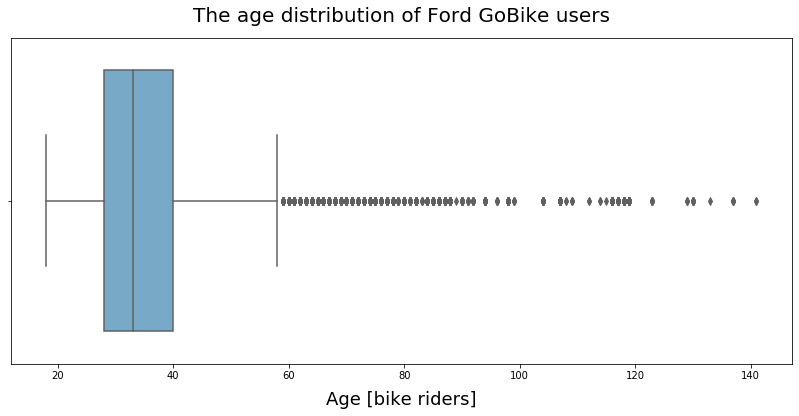

In [31]:
plt.figure(figsize=(14,6))
sns.boxplot(x='member_age', data=df, palette='Blues', orient='h')
plt.title("The age distribution of Ford GoBike users", fontsize=20, y=1.03)
plt.xlabel("Age [bike riders]", fontsize=18, labelpad=10)
plt.savefig('image01.png');

In [32]:
df['member_age'].describe()

count    1.740825e+06
mean     3.518715e+01
std      1.012318e+01
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      4.000000e+01
max      1.410000e+02
Name: member_age, dtype: float64

In [33]:
df['member_age'].values[df['member_age'] > 60] = 35 

In [34]:
df['member_age'].describe()

count    1.740825e+06
mean     3.457585e+01
std      9.017304e+00
min      1.800000e+01
25%      2.800000e+01
50%      3.300000e+01
75%      3.900000e+01
max      6.000000e+01
Name: member_age, dtype: float64

#### Usage Distribution
Bay Weels propose 2 kind of usage, either you use the system often and it is better that you become a `subscriber`, either you use it once in a while a you'll better stay a `customer`

Text(0.5, 0, 'User Type')

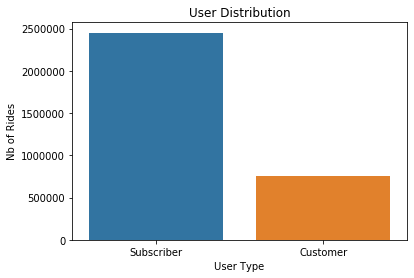

In [35]:
sns.countplot(data=df, x='user_type');
plt.title('User Distribution');
plt.ylabel('Nb of Rides');
plt.xlabel('User Type')

We see that there is far more rides done by `subscriber` than by `customers`. In my opinion, this behaviour is quite normal as you subscribe to this kind of service if you are planning to use the system frequently.

#### Do the usage of the service differs during the year ?
We'll look if there is a difference use of the service during the year. Perhaps is there seasons (Spring, Summer) where the service is more used than during some other seasons (Automn, Winter).

Text(0.5, 0, 'Month')

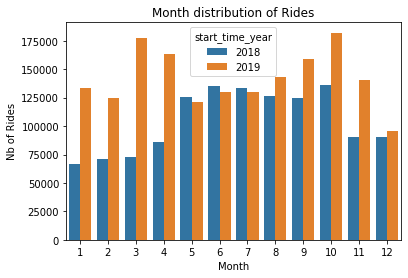

In [36]:
sns.countplot(data=df[df['start_time_year']<2020], x='start_time_month',hue='start_time_year');
plt.title('Month distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Month')

This graph shows that for both years `2018` and `2019`, there seems to be a seasonality of use of the service during `tempered` and `hot` days (`Spring`, `Summer` and `Automn`) rather than during `cold` days (`Winter`).

Difference between `2018` and `2019`, there was more travels during `Spring` and `Automn` `2019` than during `Summer` `2019` though the peak in `2018` was from `may` to `october` without a valley during `summer` (but amount of travels during those 2 summers is quite similar).

Both year have their major peak of use during the `October` month.


#### Is there some specific day of the week where the service explodes ?
Perhaps is the Bay Wheels service more used during workdays rather than during the week-end. This graphic representation should give us some hints to answer this question.

Text(0.5, 0, 'Day')

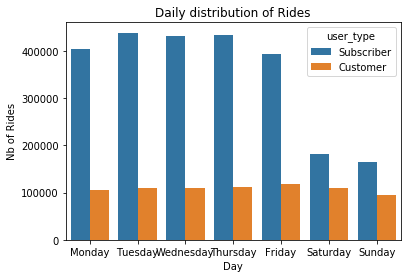

In [37]:
sns.countplot(data=df, x='start_time_dow', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'], hue='user_type');
plt.title('Daily distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Day')

It seems that the Bay Wheels service is mostly used during workdays (Monday to Friday) rather than during the week-end (Saturday and Sunday) for subscribers.

This behaviour differs for the `customers`. The `day of week` usage is more like a flat line (or a little curvy representation)

> Is the service mostly used by worker and student going from one place (Home Place) to another (Work / Study Place) rather than it is used to visit this area of SF ?

#### When are there more bike users during a normal day ?
As we have already established that the service may be used primarly by students and workers, is this behaviour confirmed by the hour of usage of the service ? Will it be mostly early in the morning (7-8AM) and early in the evening too (4-5PM) ?

Text(0.5, 0, 'Hour')

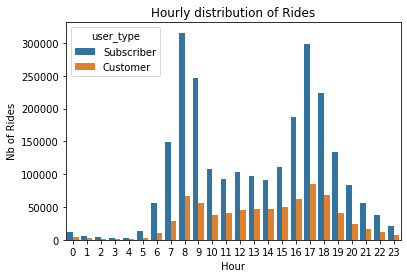

In [38]:
sns.countplot(data=df, x='start_time_hour', hue='user_type');
plt.title('Hourly distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Hour')

The behaviour we expected seems to be confirmed. There are 2 peak of usage.

First peak is in the morning between 7AM to 9AM inclusive (with the most usage to be at 8AM).

The second peak is in the evening between 4PM to 6PM inclusive (with the most usage to be at 5PM).

This could be explained if the service was mainly used by workers and students going to and back to workplace / studying place.

Strangely, there is a similitude between `subscribers` and `customers` regarding the hour of the day usage.

Lastly, we can observe that rides during night (from 11PM to 5AM) are quite inexistant.

#### What is the average duration of usage of the bike
Normaly, if the service is used to go to work / studying, the most of the usage would be less than 20 minutes top. Do we confirm this with this next representation ?


(1, 2000)

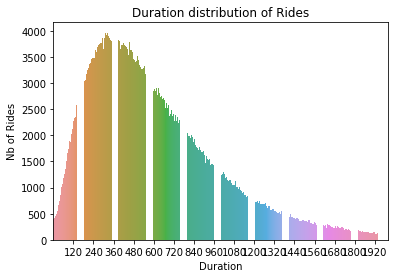

In [39]:
sns.countplot(data=df[df['duration_sec']<=2000], x='duration_sec');
plt.title('Duration distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Duration')
ticks = np.arange(0, 2000, 120)
plt.xticks(ticks, ticks);
plt.xlim(1,2000)

The most of travels are between 2 minutes (120 seconds) to 12 minutes (720 seconds). So the users are doing mostly short travels rather than long rides with this service.

#### What category of age are the users of the service ?
We should expect having relatively young users rather than over 40's. But will the graph confirm this behaviour ?

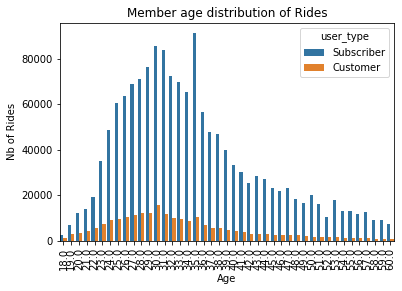

In [40]:
chart=sns.countplot(data=df, x='member_age', hue='user_type');
plt.title('Member age distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Age')
#ticks = np.arange(18, df.member_age.max(), 5)
#plt.xticks(ticks, ticks);
#plt.xlim(0,60)
nodisp=chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

As expected, population of users is mostly between 2 ages : 24 and 38.
Particularity, there is an highly peak 35 for the `subscriber` population, this may have been an anomaly but if we remembers the cleaning process, we moved the outlers from the dataset by setting their age to the mean value `35`.

#### What is the gender distribution of the system ?
This time I won't make any guess on the result, but I assume that the `man` population would be much higher than the `woman` population, just to reflect the old but still existing "Man goes to work, Woman stay at home"

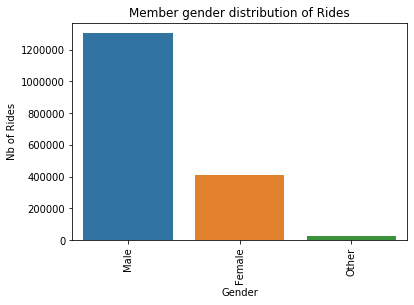

In [41]:
chart=sns.countplot(data=df, x='member_gender', order=['Male', 'Female', 'Other']);
plt.title('Member gender distribution of Rides');
plt.ylabel('Nb of Rides');
plt.xlabel('Gender')
nodisp=chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

OK, so there are a lot of men using the Bay Wheels service. But I'm really not sure what kind of explanation we could come up to explain such difference between the 2 genders (3, but Other is minority here)

### Discuss the distribution(s) of your variable(s) of interest. Were there any unusual points? Did you need to perform any transformations?

> I had trouble representing the duration of rides because the graph was really right skewed and it showed a long long tail. I almost thought using a log representation, but we had lost some information in doing this, so I prefered to limit the data to between 1 and 2000 seconds, which was the most representative travels.

### Of the features you investigated, were there any unusual distributions? Did you perform any operations on the data to tidy, adjust, or change the form of the data? If so, why did you do this?

> I had to do some transformation of the data given in the original source. 
> By example, I substracted the `year` of the `travel` to the `member_birthdate_year` to generate the `member_age`.
> I also extracted `month`, `day of the week`, `hour` from the `travel date`
> Finally, to not get bizarre results for the `monthly usage` I had to do the graphic on 2018 and 2019 which were complete years dataset and remove the first 3 months of the 2020. (I could have removed the 3 first months of 2018 to achieve almost similar results).

## Bivariate Exploration

#### Do everybody goes from and to the same place ?
We'll be using a map representation depicting the "usage" of certain station for beginning and ending the travels during the 2 Hot Hours we have seen before : 8AM and 5PM.

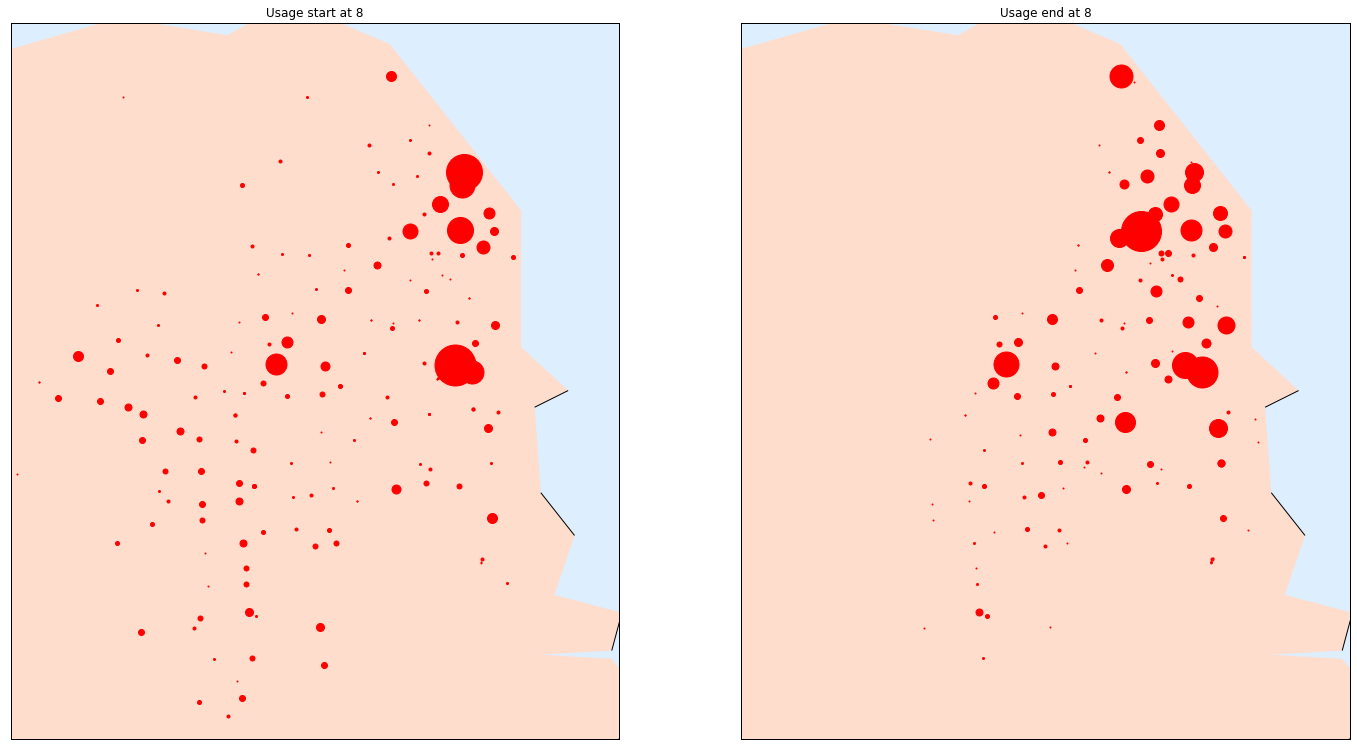

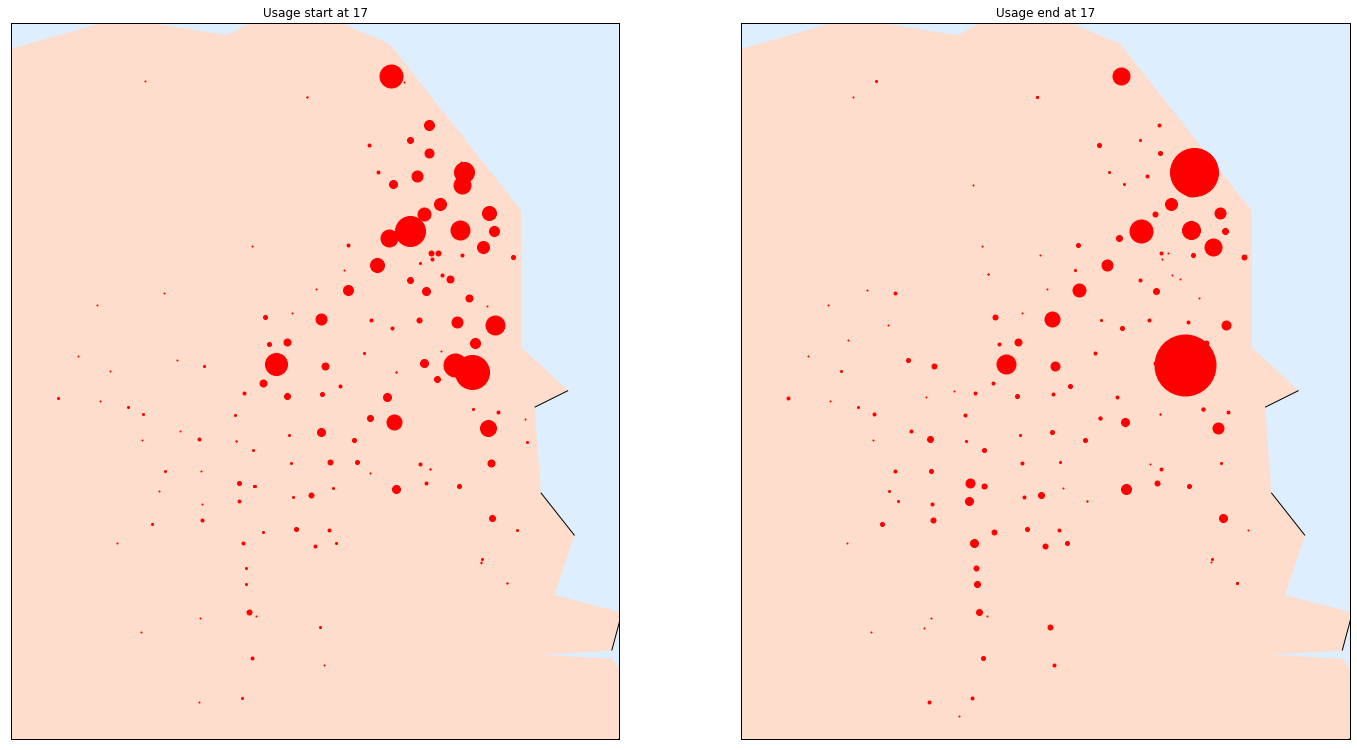

In [42]:
import warnings
from mpl_toolkits.basemap import Basemap
warnings.filterwarnings('ignore')

fig, ax = plt.subplots(1, 2, figsize=(24, 16))
fig2, ax2 = plt.subplots(1, 2, figsize=(24, 16))

def drawMap(df, travelPosition: str, hour: int, axIn):
    """
        This function will help us to draw a map of the hot spots
        for the area of San Francisco Bay (region 3)
        
        Parameters:
        -----------
            - df: Dataframe. The dataframe containing datas we need to draw the map
            - travelPosition: str. Travel Position will determine whether you begin your travel `start` or
                you are at the `end`. These are the only 2 values authorized (`start`, `end`)
            - hour: int. The hour of the day you want the hot spot graph (between 0 and 23 inclusive)
        
        Returns:
        --------
            Display a map of hot spots for the specific hour and position in the travel
    """
    valid = {'start', 'end'}
    if dayPeriod not in valid:
        raise ValueError("error: param dayPeriod must be one of %r." % valid)
    if ((hour < 0) | (hour > 23)):
        raise ValueError("error: param hour must be between 0 and 23 inclusive.")
    df_stations = df[df[f'{dayPeriod}_time_hour']==hour].groupby([f'{dayPeriod}_station_longitude', f'{dayPeriod}_station_latitude']).count().reset_index()

    m = Basemap(projection='gnom', lat_0=37.804444, lon_0=-122.270833, 
            llcrnrlon=-122.45, llcrnrlat=37.74, 
            urcrnrlon=-122.375, urcrnrlat=37.81,
            resolution='h', ax=axIn
           )
    
    m.fillcontinents(color="#FFDDCC", lake_color='#DDEEFF')
    m.drawmapboundary(fill_color="#DDEEFF")
    m.drawcoastlines()
    axIn.set_title(f'Usage {dayPeriod} at {hour}')
    
    for ind in df_stations.index: 
        x,y = m(df_stations[f'{dayPeriod}_station_longitude'][ind], df_stations[f'{dayPeriod}_station_latitude'][ind]) 
        m.plot(x, y, 'ro', markersize=int(df_stations['bike_id'][ind]/400))


for i, dayPeriod in enumerate(['start', 'end']):    
    drawMap(df, dayPeriod, 8, ax[i])

for i, dayPeriod in enumerate(['start', 'end']):    
    drawMap(df, dayPeriod, 17, ax2[i])


As previsible, the `start 8AM` looks similar do the `end 5PM` and the `end 8AM` to the `start 5PM`.
We can also see that people comes from the suburb area (South West) to the center and north east area. I do not clearly know how SF is build, but it looks like suburban areas in South West are mainly Residencial zone and the hot spots we see in `end 8AM` should be the Financial Zone.

Before dealing with all other information, I'll cut the dataset to all travels below 2000 seconds as we have seen that it was the most representative of the lot.

In [43]:
df = df[df['duration_sec']<=2000]

#### Let's see if there is a correlation between duration and gender


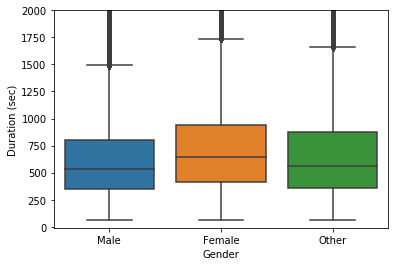

In [44]:
sns.boxplot(data = df, x = 'member_gender', y = 'duration_sec')
plt.ylim([-10, 2000])
plt.xlabel('Gender')
plt.ylabel('Duration (sec)')
plt.show()

We saw that there was more men using the service than female or other, but it looks like here than women and other are getting longer travels than men.

#### Let's see if there is a correlation between duration and user type

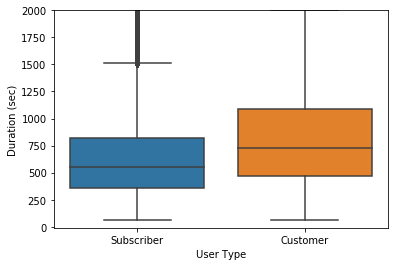

In [45]:
sns.boxplot(data = df, x = 'user_type', y = 'duration_sec')
plt.ylim([-10, 2000])
plt.xlabel('User Type')
plt.ylabel('Duration (sec)')
plt.show()

Once again, subscriber were the most users of the service, but we can see here that customers are traveling longer with the bike than subscribers. This could be explained by a lot of scenarios (like subscribers are accustomed to the traffic or itinary and customers to do the same distance, may be more cautionous or slow, or that customers are more likely to use the service to `visit` and by so they take their time)

### Talk about some of the relationships you observed in this part of the investigation. How did the feature(s) of interest vary with other features in the dataset?

> By looking into the start and end station around the `commute` time, I could notice that movement seems symetric. Popularity of start station during the morning seems similar to popularity of ending station during the evening and vice versa.

### Did you observe any interesting relationships between the other features (not the main feature(s) of interest)?

> When looking for correlation between gender and duration, we could notice that wether `female` and `other` users are the fewest, they are also the population riding longest. Are they the most sportive population too ?
> Same strange behaviour appears when I was looking for correlation between `user_type` and `duration`. Wether `customer` does less travels, they are also doing the longest trip (in duration).

## Multivariate Exploration

#### Looking for relation between Gender, Age, Duration
Is there only a distinct relation between those multiple parameters ?

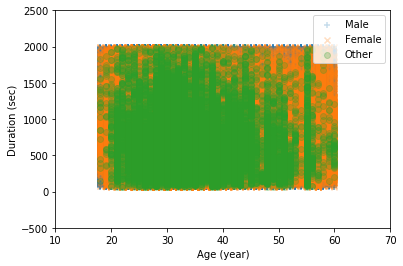

In [46]:
gender_markers = [['Male', '+'],['Female', 'x'],['Other', 'o']]

for gender, marker in gender_markers:
    df_gender = df[df['member_gender'] == gender]
    plt.scatter(df_gender['member_age'], df_gender['duration_sec'], marker = marker, alpha=0.25)
plt.legend(['Male','Female','Other'])
plt.axis([10, 70, -500, 2500 ])
plt.xlabel('Age (year)')
plt.ylabel('Duration (sec)')
plt.show()

This graphical representation is quite messy, I'll try to extract the 3 Genders into separated graphs to compare each one side by side.

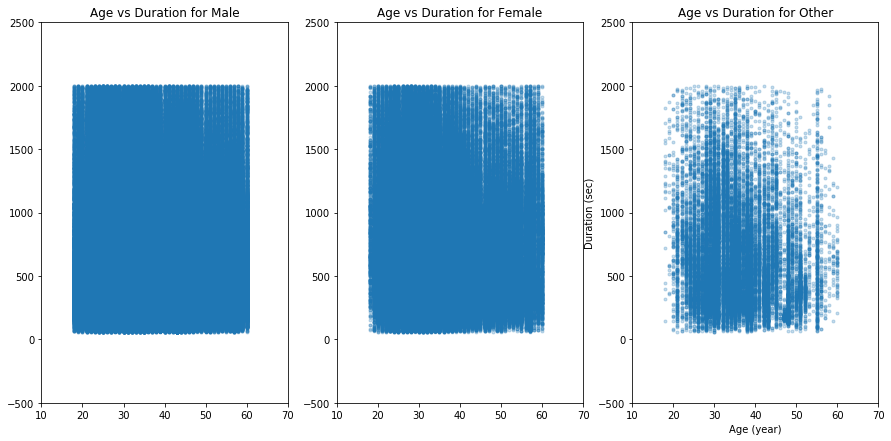

In [47]:
fig, ax = plt.subplots(1, 3, figsize=(15, 7))

genders = ['Male', 'Female', 'Other']

for i, gender in enumerate(genders):

    df_gender = df[df['member_gender'] == gender]
    ax[i].scatter(df_gender['member_age'], df_gender['duration_sec'], marker = '.', alpha=0.25)
    ax[i].set_title(f'Age vs Duration for {gender}')
    ax[i].axis([10, 70, -500, 2500 ])
    plt.xlabel('Age (year)')
    plt.ylabel('Duration (sec)')
    
    

For both gender `male` or `female` trips duration vs age seems to cover all the duration and being quite similar.
But for gender `other` we can notice that trip duration seems to be decreasing when age goes over 40. Only particularity seems to be around the age of 55 where you've got an increasing number of travel for duration between 1 to 2000 seconds.

#### What is the monthly number of rides by group age ?
Let's be curious and have a look from January 2018 to March 2020 over the number of rides by group age.

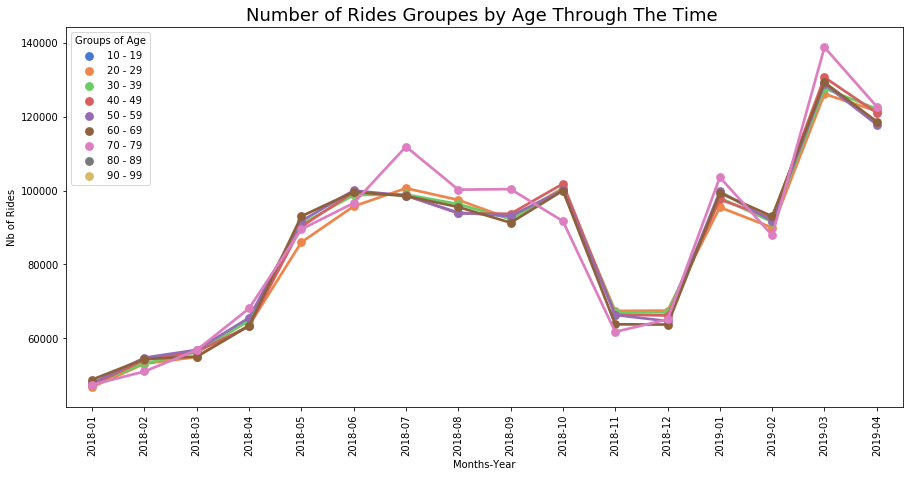

In [48]:
df_sub = df.loc[df['member_grouping_age'].isin(['20 - 29', '30 - 39', '40 - 49', '50 - 59', '60 - 69', '70 - 79'])]
plt.figure(figsize = (15, 7))
#plt.style.use('seaborn')
chart=sns.pointplot(data = df_sub.sort_values(by=['start_time_yearmonth']), x='start_time_yearmonth', y = 'index',
             hue = 'member_grouping_age', palette = 'muted', ci = None);
plt.title('Number of Rides Groupes by Age Through The Time ', fontsize = 18);
plt.legend(title = 'Groups of Age');
plt.xlabel('Months-Year');
plt.ylabel('Nb of Rides');
nodisp=chart.set_xticklabels(chart.get_xticklabels(), rotation=90)

At first, I dealt with all age group and the graph was a little bit fuzzy, so I filter age-group data from 20 to 79 which cover a lot of data available.

This plot seems simple to analyze. Perhaps to simple, so there is a lot of things to discuss about it.

* From 2018-01 To 2019-04, there seems to be quite no difference between age group concerning the usage of the bike system, a little bit odd no ?
* Since 2019-04, there is no more information about the age group, has there have been a change on this date ?

In fact, on April 2019, `Ford GoBike` changed name for `Bay Wheels` and certainly of data collection fields.

### Talk about some of the relationships you observed in this part of the investigation. Were there features that strengthened each other in terms of looking at your feature(s) of interest?

> I notice that either you are from `male` or `female` gender, both have numerous trips with almost all the spectre of duration for every age. But for `other` gender, trip are less numerous but there is a peak for the age of around 55. 

### Were there any interesting or surprising interactions between features?

> The most surprising interactions was the last discover between Age Grouping, Time (Month-Year) and Number of Rides. So much concordance is really strange.